<a href="https://colab.research.google.com/github/DhairviShah/Machine-Learning-Project/blob/main/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [8]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

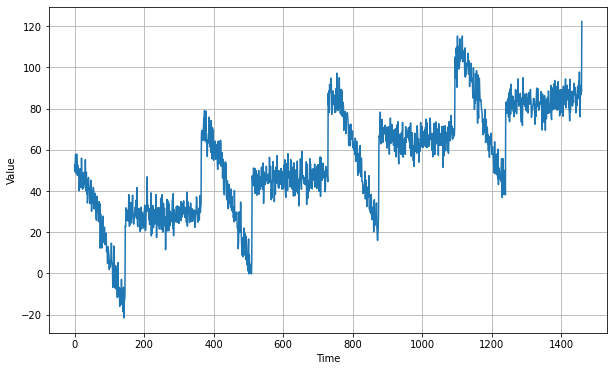

In [9]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [10]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 507.5555 - mae: 508.0552 - val_loss: 1497.1698 - val_mae: 1497.6698
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 778.1570 - mae: 778.6566 - val_loss: 2315.1946 - val_mae: 2315.6946
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 376.8672 - mae: 377.3672 - val_loss: 1561.9948 - val_mae: 1562.4948
Epoch 4/100
31/31 [==============================] - 1s 12ms/step - loss: 459.4485 - mae: 459.9478 - val_loss: 324.5573 - val_mae: 325.0573
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 605.4030 - mae: 605.9030 - val_loss: 3459.0859 - val_mae: 3459.5859
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 974.0519 - mae: 974.5519 - val_loss: 472.1842 - val_mae: 472.6842
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 838.1475 - mae: 838.6475 - val_loss: 600.5430 - val_mae: 601.0430
Epoch 8/100
31/3

KeyboardInterrupt: ignored

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 123.8442 - mae: 124.3440 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 108.2564 - mae: 108.7555 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 89.8979 - mae: 90.3976 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 70.1245 - mae: 70.6238 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 48.8592 - mae: 49.3580 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 26.1610 - mae: 26.6590 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 8.7491 - mae: 9.2376 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 7.0063 - mae: 7.4931 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 6.9446 - mae: 7.4310 - 

(1e-06, 0.001, 0.0, 20.0)

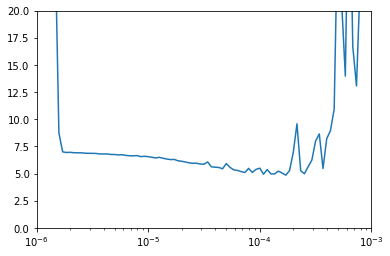

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 11ms/step - loss: 544.9420 - mae: 545.4420 - val_loss: 1157.6766 - val_mae: 1158.1766
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 850.3492 - mae: 850.8492 - val_loss: 295.0880 - val_mae: 295.5880
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 702.6100 - mae: 703.1100 - val_loss: 1024.5856 - val_mae: 1025.0856
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 651.5986 - mae: 652.0983 - val_loss: 2554.8342 - val_mae: 2555.3342
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 754.9395 - mae: 755.4395 - val_loss: 68.2335 - val_mae: 68.7330
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 518.3746 - mae: 518.8738 - val_loss: 3070.9614 - val_mae: 3071.4614
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 668.4785 - mae: 668.9783 - val_loss: 242.8822 - val_mae: 243.3822
Epoch 8/500
31/31 [=

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 7ms/step


In [18]:
lin_forecast.shape

(461,)

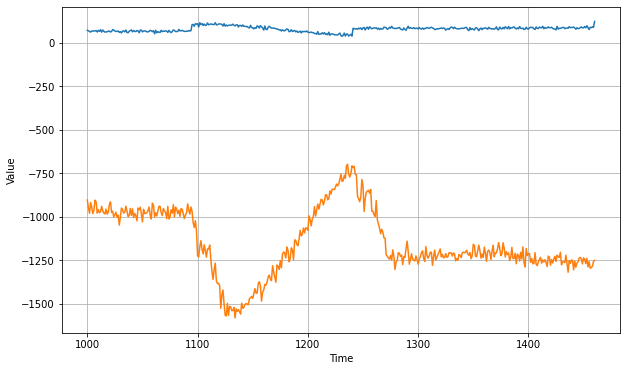

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1224.6255

### Dense Model Forecasting

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 9.3597 - mae: 9.8482 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 9.0347 - mae: 9.5228 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 8.6713 - mae: 9.1620 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 8.3048 - mae: 8.7920 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9486 - mae: 8.4394 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 7.6064 - mae: 8.0939 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.2940 - mae: 7.7800 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.0356 - mae: 7.5213 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 6.8536 - mae: 7.3399 - lr: 2.5119e-07
E

(1e-07, 0.005, 0.0, 30.0)

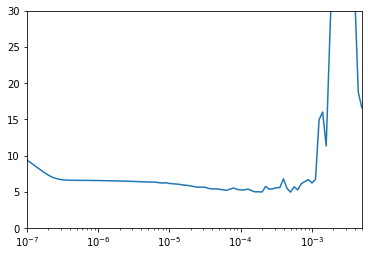

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 177.1621 - mae: 177.6594 - val_loss: 32.9966 - val_mae: 33.4931
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 19.6248 - mae: 20.1188 - val_loss: 37.0108 - val_mae: 37.5104
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 16.0884 - mae: 16.5787 - val_loss: 38.6354 - val_mae: 39.1354
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 16.0239 - mae: 16.5170 - val_loss: 36.8769 - val_mae: 37.3767
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 16.0033 - mae: 16.4973 - val_loss: 33.4893 - val_mae: 33.9883
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 16.0131 - mae: 16.5049 - val_loss: 37.6038 - val_mae: 38.1030
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 15.9957 - mae: 16.4906 - val_loss: 36.5051 - val_mae: 37.0047
Epoch 8/500
31/31 [==============================] -

In [24]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 5s 10ms/step


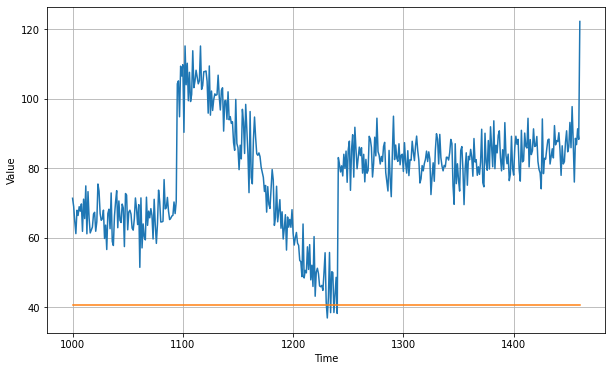

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [26]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

37.83233